In [13]:
import pandas as pd
import re

def clean_banking_data(input_filepath):
    # Load the original messy CSV
    df = pd.read_csv(input_filepath)

    # Define the bank groups present in the data
    bank_groups = [
        "Scheduled Commercial Banks",
        "Public Sector Banks",
        "Old Private Sector Banks",
        "Private Sector Banks *",
        "Foreign Banks In India",
        "Small Finance Banks"
    ]

    group_indices = {}
    for group in bank_groups:
        idx = df[df.iloc[:, 1] == group].index
        if not idx.empty:
            group_indices[group] = idx[0]

    sorted_groups = sorted(group_indices.items(), key=lambda x: x[1])
    clean_frames = []

    for i in range(len(sorted_groups)):
        name, start_idx = sorted_groups[i]
        end_idx = sorted_groups[i+1][1] if i+1 < len(sorted_groups) else len(df)

        # Slice data for the specific bank group
        subset = df.iloc[start_idx:end_idx].copy()

        # Keep only rows that look like years (e.g., 2023-24)
        data_rows = subset[subset.iloc[:, 1].str.contains(r'\d{4}-\d{2}', na=False)].copy()

        # Map the columns to meaningful names
        cols = {
            'Unnamed: 1': 'Year',
            'Unnamed: 2': 'Gross_Advances',
            'Unnamed: 3': 'Net_Advances',
            'Unnamed: 4': 'Gross_NPA_Amount',
            'Unnamed: 5': 'Gross_NPA_Percent_Advances',
            'Unnamed: 6': 'Gross_NPA_Percent_Assets',
            'Unnamed: 7': 'Net_NPA_Amount',
            'Unnamed: 8': 'Net_NPA_Percent_Advances',
            'Unnamed: 9': 'Net_NPA_Percent_Assets'
        }

        data_rows = data_rows[list(cols.keys())].rename(columns=cols)
        data_rows['Bank_Group'] = name

        # Convert text to numbers
        numeric_cols = ['Gross_Advances', 'Net_Advances', 'Gross_NPA_Amount',
                        'Gross_NPA_Percent_Advances', 'Gross_NPA_Percent_Assets',
                        'Net_NPA_Amount', 'Net_NPA_Percent_Advances', 'Net_NPA_Percent_Assets']

        for col in numeric_cols:
            data_rows[col] = pd.to_numeric(data_rows[col], errors='coerce')

        clean_frames.append(data_rows)

    # Combine everything into one master dataset
    final_df = pd.concat(clean_frames, ignore_index=True)
    return final_df

# EXECUTION
excel_filename = 'Gross and Net NPAs of Scheduled Commercial Banks - Bank Group-Wise.xlsx'
output_csv_filename = 'Gross and Net NPAs of Scheduled Commercial Banks - Bank Group-Wise.xlsx - Report 1.csv'

# Read the Excel file and save the 'Report 1' sheet as a CSV
excel_data = pd.read_excel(excel_filename, sheet_name='Report 1')
excel_data.to_csv(output_csv_filename, index=False)

# Now, call the cleaning function with the generated CSV
cleaned_data = clean_banking_data(output_csv_filename)
cleaned_data.to_csv('cleaned_bank_npas.csv', index=False)
print("Cleaned data saved as 'cleaned_bank_npas.csv'")

Cleaned data saved as 'cleaned_bank_npas.csv'


/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [17]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import shap


In [14]:
df=pd.read_csv('cleaned_bank_npas.csv')


In [16]:
df.head()

,Year,Gross_Advances,Net_Advances,Gross_NPA_Amount,Gross_NPA_Percent_Advances,Gross_NPA_Percent_Assets,Net_NPA_Amount,Net_NPA_Percent_Advances,Net_NPA_Percent_Assets,Bank_Group
0,2023-24,17508589.83,17142339.56,480818.2938,2.746185,1.7,106732.3205,0.622624,0.4,Scheduled Commercial Banks
1,2022-23,14756637.36,14319352.43,571545.5407,3.873142,2.4,135319.7062,0.945013,0.6,Scheduled Commercial Banks
2,2021-22,12750005.88,12198767.37,743639.6871,5.832465,3.4,204230.9038,1.674193,0.9,Scheduled Commercial Banks
3,2020-21,11399608.00,10806381.00,835138.0000,7.300000,4.3,258050.0000,2.400000,1.3,Scheduled Commercial Banks
4,2019-20,10918918.00,10301897.00,899803.0000,8.200000,5.0,289370.0000,2.800000,1.6,Scheduled Commercial Banks


In [18]:
df = df[df["Bank_Group"] == "Scheduled Commercial Banks"].copy()


In [19]:
# Convert "2023-24" → 2024
df["Year"] = df["Year"].str.split("-").str[1].astype(int) + 2000

df = df.sort_values("Year").reset_index(drop=True)
df.head()


,Year,Gross_Advances,Net_Advances,Gross_NPA_Amount,Gross_NPA_Percent_Advances,Gross_NPA_Percent_Assets,Net_NPA_Amount,Net_NPA_Percent_Advances,Net_NPA_Percent_Assets,Bank_Group
0,2000,475113.0,444292.0,60408.0,12.7,5.5,30073.0,6.8,2.7,Scheduled Commercial Banks
1,2001,558766.0,526328.0,63741.0,11.4,4.9,32461.0,6.2,2.5,Scheduled Commercial Banks
2,2002,680958.0,645859.0,70861.0,10.4,4.6,35554.0,5.5,2.3,Scheduled Commercial Banks
3,2003,778043.0,740473.0,68717.0,8.8,4.1,29692.0,4.0,1.8,Scheduled Commercial Banks
4,2004,902026.0,862643.0,64812.0,7.2,3.3,24396.0,2.8,1.2,Scheduled Commercial Banks


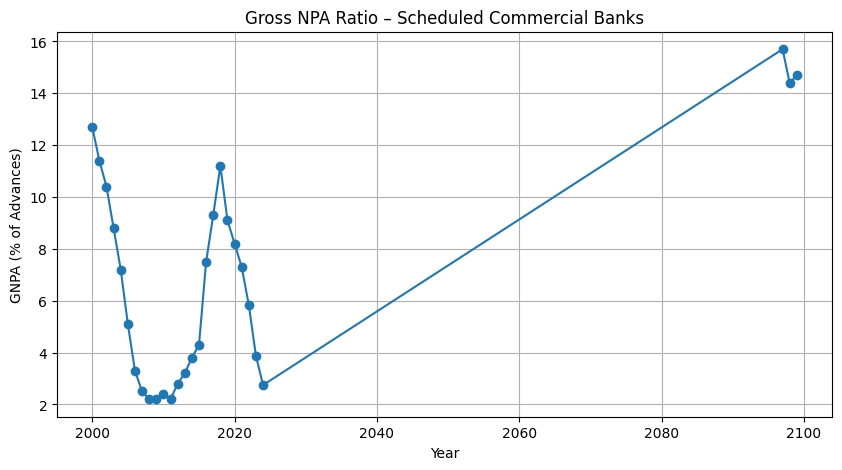

In [20]:
#Gnpa Trend
plt.figure(figsize=(10,5))
plt.plot(df["Year"], df["Gross_NPA_Percent_Advances"], marker="o")
plt.title("Gross NPA Ratio – Scheduled Commercial Banks")
plt.xlabel("Year")
plt.ylabel("GNPA (% of Advances)")
plt.grid(True)
plt.show()


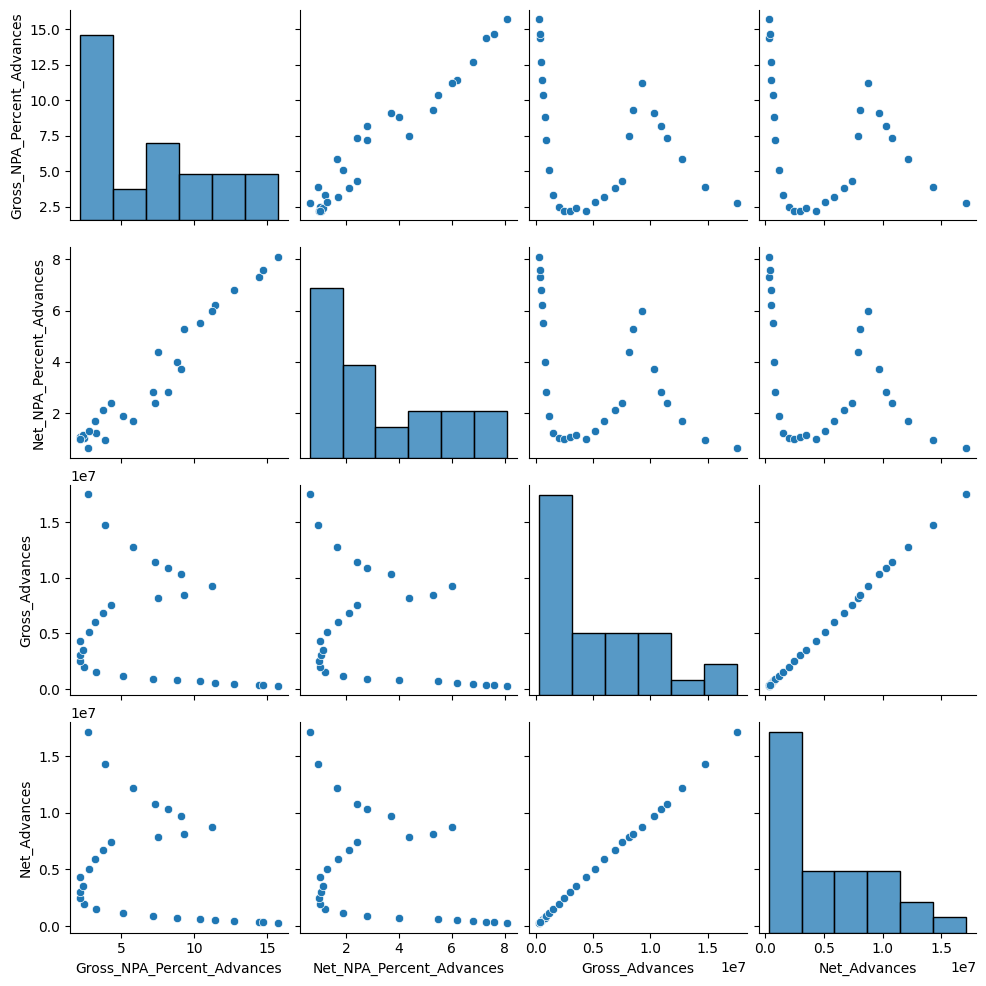

In [21]:
sns.pairplot(
    df[
        [
            "Gross_NPA_Percent_Advances",
            "Net_NPA_Percent_Advances",
            "Gross_Advances",
            "Net_Advances"
        ]
    ]
)
plt.show()


In [23]:
# Growth rates
df["Gross_Advances_Growth"] = df["Gross_Advances"].pct_change()
df["Net_Advances_Growth"] = df["Net_Advances"].pct_change()

# Lagged GNPA (path dependency)
df["GNPA_lag1"] = df["Gross_NPA_Percent_Advances"].shift(1)
df["GNPA_lag2"] = df["Gross_NPA_Percent_Advances"].shift(2)

final_df = df.dropna().reset_index(drop=True)
final_df.head()


,Year,Gross_Advances,Net_Advances,Gross_NPA_Amount,Gross_NPA_Percent_Advances,Gross_NPA_Percent_Assets,Net_NPA_Amount,Net_NPA_Percent_Advances,Net_NPA_Percent_Assets,Bank_Group,Gross_Advances_Growth,Net_Advances_Growth,GNPA_lag1,GNPA_lag2
0,2002,680958.0,645859.0,70861.0,10.4,4.6,35554.0,5.50000,2.3,Scheduled Commercial Banks,0.218682,0.227104,11.4,12.7
1,2003,778043.0,740473.0,68717.0,8.8,4.1,29692.0,4.00000,1.8,Scheduled Commercial Banks,0.142571,0.146493,10.4,11.4
2,2004,902026.0,862643.0,64812.0,7.2,3.3,24396.0,2.80000,1.2,Scheduled Commercial Banks,0.159352,0.164989,8.8,10.4
3,2005,1167684.0,1150836.0,59373.0,5.1,2.5,21754.0,1.89028,0.9,Scheduled Commercial Banks,0.294513,0.334081,7.2,8.8
4,2006,1545730.0,1516811.0,51097.0,3.3,1.8,18543.0,1.22250,0.7,Scheduled Commercial Banks,0.323757,0.318008,5.1,7.2


In [24]:
X = final_df[
    [
        "Gross_Advances_Growth",
        "Net_Advances_Growth",
        "GNPA_lag1",
        "GNPA_lag2",
        "Net_NPA_Percent_Advances"
    ]
]

y = final_df["Gross_NPA_Percent_Advances"]


In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, shuffle=False
)


In [26]:
lr_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

lr_pipeline.fit(X_train, y_train)
lr_pred = lr_pipeline.predict(X_test)

print("Linear Regression")
print("MAE:", mean_absolute_error(y_test, lr_pred))
print("R2:", r2_score(y_test, lr_pred))
print()


Linear Regression
MAE: 0.35009153272350485
R2: 0.9879734474011815



In [27]:
rf_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", RandomForestRegressor(
        n_estimators=300,
        random_state=42
    ))
])

rf_pipeline.fit(X_train, y_train)
rf_pred = rf_pipeline.predict(X_test)

print("Random Forest")
print("MAE:", mean_absolute_error(y_test, rf_pred))
print("R2:", r2_score(y_test, rf_pred))
print()


Random Forest
MAE: 2.8289174285714305
R2: 0.48089760900560896



In [28]:
gb_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", GradientBoostingRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,
        random_state=42
    ))
])

gb_pipeline.fit(X_train, y_train)
gb_pred = gb_pipeline.predict(X_test)

print("Gradient Boosting")
print("MAE:", mean_absolute_error(y_test, gb_pred))
print("R2:", r2_score(y_test, gb_pred))


Gradient Boosting
MAE: 2.617569708278149
R2: 0.646785688577221


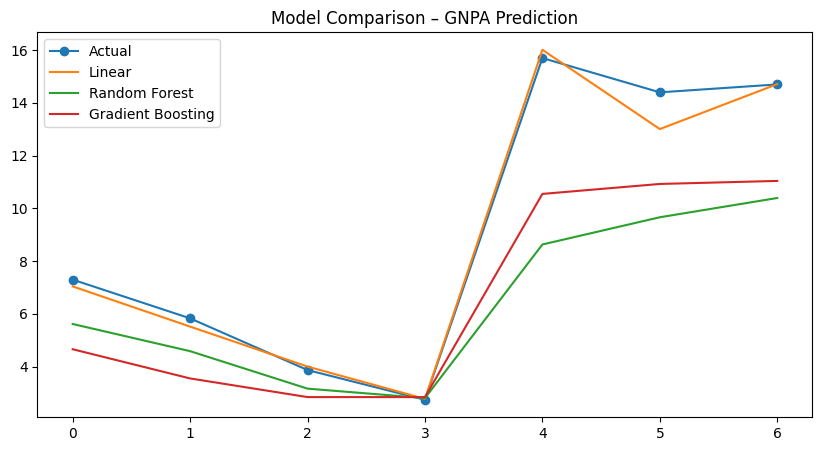

In [29]:
plt.figure(figsize=(10,5))
plt.plot(y_test.values, label="Actual", marker="o")
plt.plot(lr_pred, label="Linear")
plt.plot(rf_pred, label="Random Forest")
plt.plot(gb_pred, label="Gradient Boosting")
plt.legend()
plt.title("Model Comparison – GNPA Prediction")
plt.show()


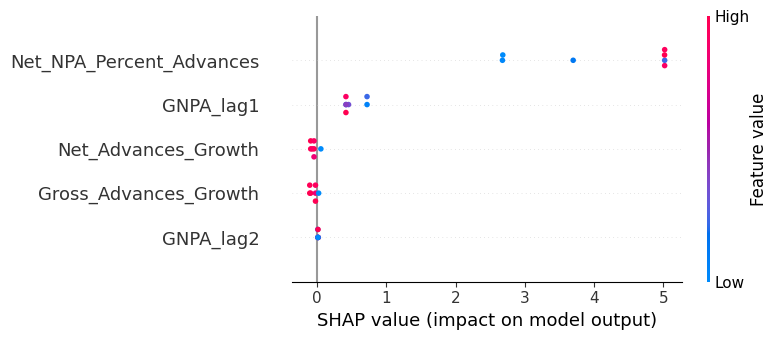

In [30]:
best_model = gb_pipeline.named_steps["model"]

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)
